In [99]:
import mesa
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
import math

def compute_consensus(model):
    agent_opinions = [agent.opinion for agent in model.schedule.agents]
    agreed_opinions = [i for i in agent_opinions if i >= 0.9]
    return len(agreed_opinions) / len(agent_opinions)



def compute_average_opinion(model):
    agent_opinions = [agent.opinion for agent in model.schedule.agents]
    return sum(agent_opinions)/len(agent_opinions)



class Agent(mesa.Agent):
        

    def __init__(self, unique_id, model, w, alpha, epsilon):
        
        super().__init__(unique_id, model)
        # Initialise each agent with an opinion on whether H1 is true. Randomly distributed between 0 and 1.
        if self.model.uniform == True:
            self.opinion = 0.5
        else:
            self.opinion = random.uniform(0,1)
        self.consensus = 0
        # Weight is the same for each agent, since we are planning to use special case in SProdOp
        self.weight = w
        self.alpha = alpha
        self.epsilon = epsilon
        
        x = random.uniform(0,1)
        
#         if x < 0.2:
#             self.stubborn = True
#             self.opinion = 1
#             if x > 0.1:
#                 self.stubborn = True
#                 self.opinion = 0.2
#         else:
#             self.stubborn = False
                    
#         self.stubborn_agents(self.model.s_proportion)
        
    
    
    def pool_agents(self):
        # Want to return the self + n neighbouring agents.
        pooled_agents = [self]
        # Random approach - randomly choose n agents, assumes 'Well-mixed' model.
        while len(pooled_agents) < self.model.pool_size:
            other_agent = self.random.choice(self.model.schedule.agents)
            if other_agent not in pooled_agents:
                pooled_agents.append(other_agent)
        return pooled_agents  
    
    
    
    def SProdOp(self, pooled_agents):
        
        # SProdOp from combining opinion pooling paper. Only works in special case when w = const.
        
        pooled_opinions = []
        
        for agent in pooled_agents:
            pooled_opinions.append(agent.opinion)
            
        w = self.weight
        
        c_x = ((np.prod(pooled_opinions))**w)  /  (  np.prod(pooled_opinions)**w   + 
                                                np.prod(list(1-np.asarray(pooled_opinions)))**w )
        
        if math.isnan(c_x) == True:
            c_x = 1
        
        for agent in pooled_agents:
            
            # We do not want to change the opinions of stubborn agents, however we want them to change the opinions of others
            
            if agent.stubborn == False:
                agent.opinion = c_x

                
                
    def bayesian_update(self):
        
        # Bayesian update according to Definition 3.1 from combining opinion pooling paper
        delta = 1 - self.alpha           
        x = self.opinion
        self.opinion = ( delta*x ) / ( (delta*x) + ((1-delta)*(1-x)) )
        
        
        
    def switched_bayesian(self):
        if self.model.STEP < 200:
            delta = 1 - self.alpha
        if self.model.STEP >= 200:
            delta = self.alpha        
        x = self.opinion
        self.opinion = ( delta*x ) / ( (delta*x) + ((1-delta)*(1-x)) )
                
            
            
    def step(self):
        # Simulate agents randomly coming comparing the two options
        x = random.uniform(0,1)
#         stubborn_pool = self.stubborn_agents(self.model.s_proportion)
#         print(len(stubborn_pool))
        
        if self.stubborn == False:        
            
            if x < self.epsilon:
                
                if self.model.dynamics == "switching":
                    self.switched_bayesian()
                    
                else:
                    self.bayesian_update()

        # I want to change it so that the pooling only occurs after every agent has moved. This would simulate agents
        # moving simulataneously

        if self.model.pooling == True:
            
            if self == self.model.schedule.agents[-1]:
                
                pooled_agents = self.pool_agents()
                self.SProdOp(pooled_agents)
                         
                    
                    
class Model(mesa.Model):
    
    

    def __init__(self, K, n, w, alpha, epsilon, pooling = False, 
                 uniform = False, dynamics = "none", measures = "none",
                s_proportion = 0):
        
        self.num_agents = K
        self.STEP = 0
        self.pooling = pooling
        self.uniform = uniform
        self.dynamics = dynamics
        self.measures = measures
        self.s_proportion = s_proportion
        # Shuffle the agents so that they are all activated once per step, and this order is shuffled at each step.
        # This is representative of the 'well mixed' scenario
        self.schedule = mesa.time.RandomActivation(self)
        self.pool_size = n
        self.running = True
    

        for i in range(self.num_agents):
            a = Agent(i, self, w, alpha, epsilon)
            self.schedule.add(a)

        self.datacollector = mesa.DataCollector(
            model_reporters = {"Average_opinion" : compute_average_opinion, "Consensus" : compute_consensus},
            agent_reporters = {"Opinion" : "opinion"})
        
        # Let's say we want 10% stubborn agents in either direction
        n_stubborn = int(self.num_agents * s_proportion)
        # Then we can find the pool of stubborn agents
        stubborn_pos_pool = self.schedule.agents[0:int(n_stubborn/2)]
        stubborn_neg_pool = self.schedule.agents[int(n_stubborn/2):n_stubborn]
        
        for agent in self.schedule.agents:
            agent.stubborn = False
            
            if agent in stubborn_pos_pool:
                agent.stubborn = True
                agent.opinion = 1
                
            if agent in stubborn_neg_pool:
                agent.stubborn = True
                agent.opinion = 0
        

    def step(self):
        self.datacollector.collect(self)
        self.STEP += 1
        self.schedule.step()

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 41.67it/s]


(0.0, 220.0)

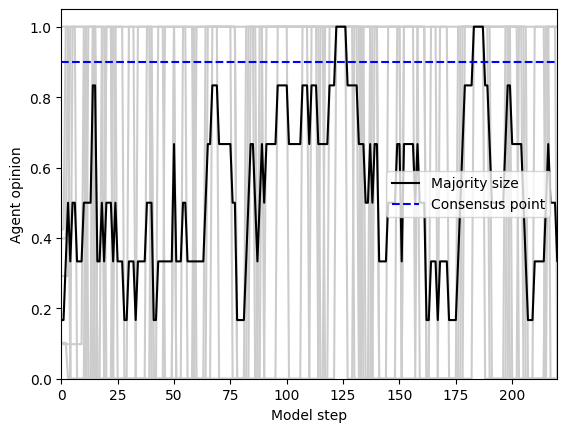

In [128]:
params = {"K": 6, "n": 2, "w": 1, "alpha": 0.1, "epsilon" : 0.02, "pooling" : False, 
          "s_proportion": 0.2, "uniform" : False, "measures": "stubborn", "dynamics" : "switching"}


results = mesa.batch_run(Model,parameters=params,number_processes=1,data_collection_period=1,display_progress=True,
    iterations=1,max_steps=500)

results_df = pd.DataFrame(results)
admired_cols = ['Step', 'Opinion']

plt.figure()
for agentID in range(params["K"]):
    agent = results_df[results_df.AgentID == agentID]
    plt.plot(agent.Step, agent.Opinion, '0.8')
    
plt.plot(results_df.Step, results_df.Consensus, color = 'black', label = 'Majority size')
plt.xlabel("Model step")
plt.ylabel("Agent opinion")
plt.axhline(y = 0.9, color = 'b', linestyle = 'dashed', label = 'Consensus point')
plt.legend(loc = 5)
plt.ylim(0,1.05)
plt.xlim(0, 220)

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.61it/s]


(0.0, 1.1)

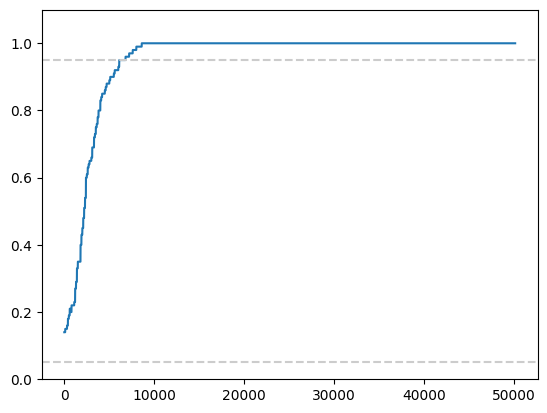

In [81]:
params = {"K": 100, "n": 3, "w": 0.5, "alpha": 0.1, "epsilon" : 0.04, "pooling" : True, 
          "s_proportion": 0.1, "uniform" : False, "measures": "stubborn", 
          "dynamics" : "switching", "s_proportion" : 0}


results = mesa.batch_run(Model,parameters=params,number_processes=1,data_collection_period=1,display_progress=True,
    iterations=1,max_steps=500)
results_df = pd.DataFrame(results)

plt.figure()
results_df.Consensus.plot()

plt.axhline(y = 0.95, color = '0.8', linestyle = 'dashed')
plt.axhline(y = 0.05, color = '0.8', linestyle = 'dashed')

plt.ylim([0,1.1])


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\Joshg\AppData\Local\Temp\ipykernel_17148\2640574431.py:96: RuntimeWarning: invalid value encountered in scalar divide
  c_x = ((np.prod(pooled_opinions))**w)  /  (  np.prod(pooled_opinions)**w   +
100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.21it/s]


Text(0, 0.5, 'Average opinion')

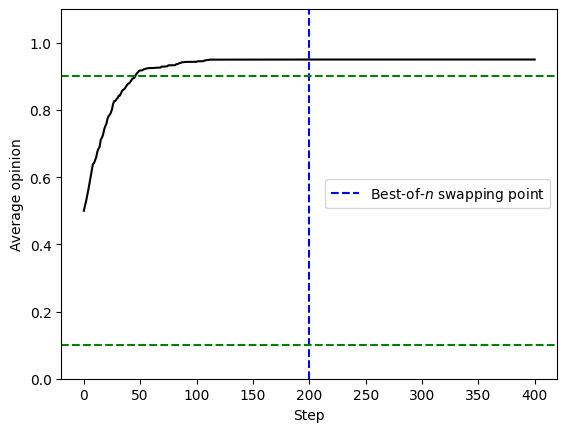

In [103]:
params = {"K": 100, "n": 3, "w": 0.5, "alpha": 0.2, "epsilon" : 0.05,
          "pooling" : True, "uniform" : True, "dynamics" : "none",
          "measures" : "stubborn", "s_proportion" : 0.1}

iterations = 1

results = mesa.batch_run(Model,parameters=params,number_processes=1,
                         data_collection_period=1,display_progress=True,
    iterations = iterations, max_steps=400)

results_df = pd.DataFrame(results)

plt.figure()
data = []
for it in range(iterations):
    results_it = results_df[results_df.iteration == it]
#     results_it = results_it.drop(columns = [col for col in results_it.columns if col not in admired_cols])
#     results_it.drop_duplicates()
    data.append(results_it.Average_opinion)
    
plt.plot(results_it.Step, np.mean(np.array(data), axis=0), color = 'black')
# plt.title("Average opinion against step. K = 100, n = 3, alpha = 0.1, epsilon = 0.02, its = 30")
# plt.axhline(y = 0.9, color = 'gray', linestyle = 'dashed', label = 'H1 Consensus point')
# plt.axhline(y = 0.1, color = 'green', linestyle = 'dashed', label = 'H2 Consensus point')
plt.axvline(x = 200, color = 'blue', linestyle = 'dashed', label = 'Best-of-$n$ swapping point')
plt.axhline(y = 0.1, color = 'g', linestyle = 'dashed')#, label = 'Best-of-$n$ swapping point')
plt.axhline(y = 0.9, color = 'g', linestyle = 'dashed')#, label = 'Best-of-$n$ swapping point')

plt.legend(loc = 5)
# plt.xlim(0,600)
plt.ylim(0,1.1)
plt.xlabel("Step")
plt.ylabel("Average opinion")